In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
import pickle
import math

from src import acgraph as acg
from src import bcloader as bcl
from src import utils as ut
from src import bcgraph as bcg
from efficient_apriori import apriori

from importlib import reload
acg = reload(acg)
bcl = reload(bcl)
bcg = reload(bcg)

### Load access control graph

In [5]:
rel_attnames = [
#'MGR_ID',
#'ROLE_ROLLUP_1',
'ROLE_ROLLUP_2',
'ROLE_DEPTNAME',
'ROLE_TITLE',
'ROLE_FAMILY_DESC',
'ROLE_FAMILY']
gur = acg.load_azkag_graph(rel_attnames=rel_attnames, isWeighted=True)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))

---Control Access Graph---
Total edges: 30872
Total vertices: 16524
Num users: 9298
Num resources: 7226


In [6]:
maxcc_gur = acg.get_largestcc(gur)
print('---Largest Connected Component---')
print('Total edges:', len(maxcc_gur.es))
print('Total vertices:', len(maxcc_gur.vs))

maxcc_usrlabels,maxcc_reslabels = acg.get_labels(maxcc_gur, byweights=False)
print('Num users:',len(maxcc_usrlabels))
print('Num resources:', len(maxcc_reslabels))

---Largest Connected Component---
Total edges: 30425
Total vertices: 15773
Num users: 8933
Num resources: 6840


### Load graph of bicliques

In [7]:
with open('data_structures/maxcc_azkag_bcs_v2.pkl', 'rb') as f:
    bcs = pickle.load(f)

print('total bicliques:', len(bcs))

total bicliques: 17563


In [8]:
subbcs = []
for bc in bcs:
    if bc.get_pattern() != None and len(bc.get_pattern()) >= 1:
        nusr = len(bc.get_usrids())
        nres = len(bc.get_resids())
        subbcs.append(bc)

print('Selected bicliques:', len(subbcs))

Selected bicliques: 12263


In [9]:
#Mapping: biclique ids to their respective indexes in subbcs
bcid_to_bcidx = dict()
for bcidx,bc in enumerate(subbcs):
    bcid = bc.get_id()
    bcid_to_bcidx[bcid] = bcidx

In [10]:
with open('data_structures/azkag_bcgraph.pkl', 'rb') as f:
    bcgraph = pickle.load(f)

### Extract frequent patterns

In [11]:
#Extract pattern from each biclique in the bcgraph
group_patts = []
for bcv in bcgraph.vs:
    bcidx = bcid_to_bcidx[bcv['bcid']]
    group_patts.append(subbcs[bcidx].get_pattern())

In [12]:
#Approximation
s = 0.0005
print('Num bicliques per frequent pattern:', s*len(bcgraph.vs))
#TODO: average numbcs per graph-pattern

Num bicliques per frequent pattern: 6.1315


In [13]:
#Compute frequent itemsets
#freq_itemsets,_ = apriori(group_patts, min_support=s, min_confidence=1.0)
#with open('data_structures/azkag_pec_fis.pkl', 'wb') as f:
#    pickle.dump(freq_itemsets, f)

In [14]:
with open('data_structures/azkag_pec_fis.pkl', 'rb') as f:
    freq_itemsets = pickle.load(f)

In [15]:
#Filter itemsets that are closed
freq_itemsets_ = ut.filter_closed(freq_itemsets)

In [16]:
#Collect attribute-value patterns
patts = []
for k,fis_list in freq_itemsets_.items():
    if k > 1:
        for fis,freq in fis_list.items():
            patts.append(list(fis))
            
print('Num of frequent patterns:', len(patts))

Num of frequent patterns: 1672


In [17]:
#Mapping: frequent pattern to their respective bicliques in the bcgraph
pattidx_to_bcvidxs = dict()
for bcvidx,bcv in enumerate(bcgraph.vs):
    bcidx = bcid_to_bcidx[bcv['bcid']]
    p = subbcs[bcidx].get_pattern()
    for pattidx,patt in enumerate(patts):
        if len(set(patt)-set(p)) == 0:
            if not pattidx in pattidx_to_bcvidxs:
                pattidx_to_bcvidxs[pattidx] = []
            pattidx_to_bcvidxs[pattidx].append(bcvidx)
            

In [18]:
#Create corresponding set of graph-patterns
gps_final = []
for pattidx,bcvidxs in pattidx_to_bcvidxs.items():
    pruned_bcgraph = bcgraph.subgraph(bcvidxs)
    ccs = pruned_bcgraph.connected_components(mode='weak')
    #Create a graph-pattern for each connected component
    for cc in ccs:
        bcids = [pruned_bcgraph.vs[bcvidx]['bcid'] for bcvidx in cc]
        gps_final.append((patts[pattidx],bcids))

In [19]:
print('Number of equivalent gps:', len(gps_final))

Number of equivalent gps: 15586


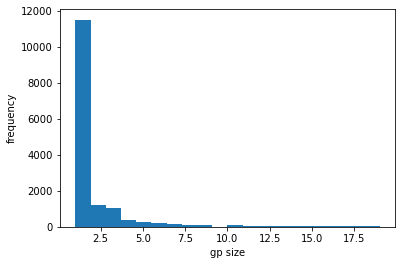

In [20]:
#Size distribution of the corresponding graph-patterns
gps_sizes = [len(gp[1]) for gp in gps_final if len(gp[1]) < 20]

plt.hist(gps_sizes, bins = 20)
plt.xlabel('gp size')
plt.ylabel('frequency')
plt.show()

In [21]:
#Collect covered bcs in the bcgraph
bcvindexes_set = set()
for patt in patts:
    for bcvidx,gpatt in enumerate(group_patts):
        if len(set(patt)&set(gpatt)) == len(patt):
            bcvindexes_set.add(bcvidx)

In [22]:
#Evaluate resource coverage
covered_residsset = set()
for bcvidx in list(bcvindexes_set):
    bcid = bcgraph.vs[bcvidx]['bcid']
    bc = subbcs[bcid_to_bcidx[bcid]]
    for resid in bc.get_resids():
        covered_residsset.add(resid)

count_res = 0
count_res2 = 0
for v in maxcc_gur.vs:
    if v['type'] == True:
        if len(maxcc_gur.neighbors(v)) < 4.44:
            resid = int(v['name'][6:])
            if resid in covered_residsset:
                count_res += 1
            count_res2 += 1
print('Res coverage:', count_res/count_res2)          

Res coverage: 0.9887837364178058


### Compute peculiarity and diversity

In [23]:
bcid_to_attvalset = dict()
for bc in subbcs:
    bcid = bc.get_id()
    bcid_to_attvalset[bcid] = set(bc.get_pattern())
    
bcid_to_bcvidx = dict()
for bcv in bcgraph.vs:
    bcid = bcv['bcid']
    bcid_to_bcvidx[bcid] = bcv.index
    
#Los vertices cubiertos
covered_bcids = set()
for gp in gps_final:
    covered_bcids |= set(gp[1])

In [24]:
#Compute peculiarities with d=2
ps = []

for gp in gps_final:
    
    #Obtain neighboring set
    bcvidxs_set = set()
    neighidxs_set = set()
    neighidxs_set2 = set()

    for bcid in gp[1]:
        if bcid in covered_bcids:
            bcvidx = bcid_to_bcvidx[bcid]
            bcv = bcgraph.vs[bcvidx]
            neighidxs = bcgraph.neighbors(bcv)
            neighidxs_set |= set(neighidxs)

            for neighidx in neighidxs:
                neigh = bcgraph.vs[neighidx]
                neighidxs2 = bcgraph.neighbors(neigh)
                neighidxs_set2 |= set(neighidxs2)

        bcvidxs_set.add(bcvidx)
    
    neighidxs_set -= bcvidxs_set
    neighidxs_set2 -= neighidxs_set
    neighidxs_set = neighidxs_set2

    #Compute dissimilarity for each attribute-value
    attval_to_count = {attval:0 for attval in gp[0]}
    for neighidx in list(neighidxs_set):
        neigh = bcgraph.vs[neighidx]
        bcid = neigh['bcid']
        if bcid in covered_bcids:
            attvalset = bcid_to_attvalset[bcid]
            for attval in gp[0]:
                if not attval in attvalset:
                    attval_to_count[attval] += 1 

    numneighs = len(neighidxs_set)
    if numneighs == 0:
        numneighs = 1

    #Compute peculiarity
    attval_to_count = {attval:count/numneighs for attval,count in attval_to_count.items()}
    p = sum([count for attval,count in attval_to_count.items()])/len(gp[0])
    ps.append(p)

    #For debug
    #print(p)
    #print(len(gp[0]))
             

In [25]:
print('Diversity:', sum(ps)/len(ps))

Diversity: 0.5943054382052373


Weibull parameters: 3.020517327966392 0.03560478034957462 0.4127674001921662


/var/folders/4z/6ntcmwbx3_s3ybystwpytzsw0000gn/T/ipykernel_1958/3441358022.py:4: RuntimeWarning: invalid value encountered in power
  y = (a / n) * ((1-gamma-x) / n)**(a - 1) * np.exp(-((1-gamma-x) / n)**a)


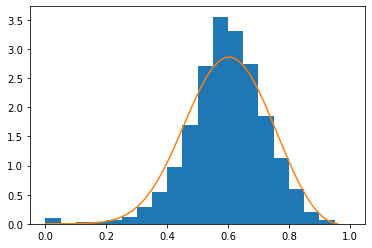

In [26]:
from scipy import stats

def weib_in_one(x,n,a,l):
    y = (a / n) * ((1-gamma-x) / n)**(a - 1) * np.exp(-((1-gamma-x) / n)**a)
    return y

bins = range(0, 21, 1)
bins = [b/(len(bins)-1) for b in bins]
x_hist, bins, p_hist = plt.hist(ps, bins = bins, density=True)
#plt.axis([0, 1, 0, 0.2])

np_ps = np.array(ps)
np_ps = 1 - np_ps
(beta,gamma,eta) = stats.weibull_min.fit(np_ps, loc=0)
print('Weibull parameters:', beta, gamma, eta)

x = np.linspace(0, 1, 50)
y = weib_in_one(x, eta, beta, gamma)
plt.plot(x, y)

plt.show()

In [27]:
#Save peculiariy values
#f = open('azkag_pfis.dat','w')
#for p in ps:
#    f.write(str(p))
#    f.write('\n')
#f.close()

In [28]:
#Save weibull curve
#f = open('azkag_pfiswei.dat','w')
#for i,x_val in enumerate(x):
#    f.write(str(x_val))
#    f.write('\t')
#    f.write(str(y[i]))
#    f.write('\n')
#f.close()